In [296]:
import numpy as np
total = [0]
def my_matmult(m1, m2):
    ans_mat = np.empty((0,m2.shape[1]))
    for row in m1:
        ans_row = np.array([])
        for col in m2.T:
            ans_row = np.append(ans_row, np.dot(row, col))
            total[0] += len(row)*2
        ans_mat = np.vstack((ans_mat,ans_row))
    return ans_mat

a = np.random.rand(3, 2)
b = np.random.rand(2, 3)

print(np.array_equal(a@b, my_matmult(a,b)))


True


In [297]:
def tensor_product(m1, m2):
  ans = np.empty( (0, m1.shape[-2], m2.shape[-1]) )
  for i in range(m1.shape[0]):
    matmult = np.expand_dims(my_matmult(m1[i], m2[i]), axis=0)
    ans = np.vstack((ans, matmult))
  return ans

a = np.random.rand(2, 3, 4)
b = np.random.rand(2, 4, 2)

print(np.allclose(tensor_product(a,b), a @ b))


True


In [298]:
def nd_tensor_product(m1, m2):
  ans_shape = m1.shape[:-2] + (m1.shape[-2], m2.shape[-1])
  ans = np.empty(ans_shape)
  for i in range(m1.shape[0]):
    if len(m1.shape) == 3:
        ans[i] = my_matmult(m1[i], m2[i])

    else:
        ans[i] = nd_tensor_product(m1[i], m2[i])
  return ans

a = np.random.rand(12, 4, 64)
b = np.random.rand(12, 64, 4)

total = [0]

print(np.allclose(nd_tensor_product(a,b), a @ b))
print(total)

True
[24576]


# Quantization

In [2]:
import numpy as np
import math

In [357]:
def matix_absmax_quantization(m1, int_type=np.int8):
    data_max = np.iinfo(int_type).max
    norm_range = math.floor((data_max)**(1/2)/ max(m1.shape))
    quantification_constant = norm_range/np.max(abs(m1))
    new_type = (m1 * quantification_constant).astype(int_type)
    assert np.all((new_type >= -1*norm_range) & (new_type <= norm_range))

    return new_type, quantification_constant

In [358]:
def matrix_quant_matmul(m1, m2):
    m1, m1_const = matix_absmax_quantization(m1, qualtization_type)
    m2, m2_const = matix_absmax_quantization(m2, qualtization_type)

    ans = np.matmul(m1,m2)

    ans = (ans.astype(np.float64))/ (m1_const * m2_const)
    return ans

def vector_quant_matmul(m1, m2):
    matrix = np.empty((m1.shape[0], m2.shape[-1]))
    for row_num in range(len(m1)):
        for col_num in range(m2.shape[-1]):
            row = m1[row_num]
            col = m2[:, col_num]
            int_row, row_const = matix_absmax_quantization(row, qualtization_type)
            int_col, col_const = matix_absmax_quantization(col, qualtization_type)
            int_dot = np.dot(int_row, int_col)
            float_dot = int_dot.astype(np.float64)* 1/(row_const * col_const)
            if np.isnan(float_dot):
                float_dot = 0
            matrix[row_num][col_num] = float_dot
    return matrix

def nd_tensor_product(m1, m2, matrix=True):
    ans_shape = m1.shape[:-2] + (m1.shape[-2], m2.shape[-1])
    ans = np.empty(ans_shape)
    if len(ans_shape) < 3:
        return matrix_quant_matmul(m1, m2) if matrix else vector_quant_matmul(m1, m2)
    else:
        for i in range(ans_shape[0]):
            ans[i] = nd_tensor_product(m1[i], m2[i], matrix=matrix)
    return ans


In [361]:
vec_smaller = 0
iterations = 1000
qualtization_type = np.int64

matrix_diff = 0
vec_diff = 0


for _ in range(iterations):
    a = np.random.uniform(-20, 20, size=(2, 10, 4))
    b = np.random.uniform(-20, 20, size=(2, 4, 10))

    actual = a @ b

    mx_quantized = nd_tensor_product(a,b, matrix = True)
    # print(f"{mx_quantized=}")
    mx_loss = np.abs(np.mean(mx_quantized - actual))
    matrix_diff += mx_loss
    # print(f'matrix loss: {mx_loss}')

    vec_quantized = nd_tensor_product(a,b, matrix = False)
    # print(f"{vec_quantized=}")
    vec_loss = np.abs(np.mean(vec_quantized - actual))
    # print(vec_loss)
    vec_diff += vec_loss
    # print(f'vec loss: {vec_loss}')
    if vec_loss < mx_loss:
        vec_smaller += 1


print(f'% vec better {vec_smaller/iterations}')
print(f'mtx loss {matrix_diff/iterations}')
print(f'vec loss {vec_diff/iterations}')

% vec better 0.882
mtx loss 8.205929315715846e-08
vec loss 2.285062211066629e-08


# Zeropoint Quantization

In [26]:
def zeropoint_quantization(x, data_type):
    data_range = np.iinfo(data_type).max- np.iinfo(data_type).min
    q_c = data_range / (np.max(x)- np. min(x))
    z_p = -1* np.round(q_c * np.min(x)) - 128
    type_x = np.round(q_c * x + z_p).astype(data_type)
    return ((type_x - z_p )/ q_c).astype(np.float64)


a = np.random.uniform(-20, 20, size=(10))
print(a)
print(zeropoint_quantization(a, np.int8))

[ -3.81947852  16.85851024 -16.94883347  -9.36529621   1.06620353
 -13.45042167   2.14239435 -17.07961161  -5.89922935  -1.76337706]
<class 'numpy.int8'>
[ -3.85962954  16.90251559 -16.90251559  -9.31634717   1.06472539
 -13.44215807   2.12945078 -17.03560626  -5.85598965  -1.73017876]


In [61]:
def zeropoint_quantization(x, data_type):
    data_range = np.iinfo(data_type).max- np.iinfo(data_type).min
    q_c = data_range / (np.max(x)- np. min(x))
    z_p = -1* np.round(q_c * np.min(x)) + np.iinfo(data_type).min
    type_x = np.round(q_c * x + z_p).astype(data_type)
    return type_x, q_c, z_p


# a = np.random.uniform(-20, 20, size=(10))
# print(a)
# print(zeropoint_quantization(a, np.int8))

In [72]:
def vector_quant_matmul(m1, m2):
    matrix = np.empty((m1.shape[0], m2.shape[-1]))
    for row_num in range(len(m1)):
        for col_num in range(m2.shape[-1]):
            row = m1[row_num]
            col = m2[:, col_num]
            int_row, row_const, row_zero = zeropoint_quantization(row, qualtization_type)
            int_col, col_const, col_zero = zeropoint_quantization(col, qualtization_type)
            int_dot = np.dot(int_row - row_zero, int_col- col_zero)
            float_dot = (int_dot /(row_const * col_const)).astype(np.float64)
            if np.isnan(float_dot):
                float_dot = 0
            matrix[row_num][col_num] = float_dot
    return matrix

def nd_tensor_product(m1, m2, matrix=True):
    ans_shape = m1.shape[:-2] + (m1.shape[-2], m2.shape[-1])
    ans = np.empty(ans_shape)
    if len(ans_shape) < 3:
        return matrix_quant_matmul(m1, m2) if matrix else vector_quant_matmul(m1, m2)
    else:
        for i in range(ans_shape[0]):
            ans[i] = nd_tensor_product(m1[i], m2[i], matrix=matrix)
    return ans


In [74]:
qualtization_type = np.int32
a = np.random.uniform(-20, 20, size=(2,3))
b = np.random.uniform(-20, 20, size=(3,4))

actual = a @ b

vec_quantized = nd_tensor_product(a,b, matrix = False)

print(actual)
print(vec_quantized)


[[-115.50278182  -46.11525114   35.05039982 -483.37567864]
 [   6.81018286  256.69913419 -450.89811225   58.91757364]]
[[-115.50278179  -46.11525112   35.05039982 -483.37567866]
 [   6.8101829   256.69913423 -450.89811231   58.91757358]]


# Zeropoint or absmax Quantization together

In [89]:
def matix_absmax_quantization(m1, int_type=np.int8):
    data_max = np.iinfo(int_type).max
    norm_range = math.floor((data_max)**(1/2)/ max(m1.shape))
    quantification_constant = norm_range/np.max(abs(m1))
    new_type = (m1 * quantification_constant).astype(int_type)
    assert np.all((new_type >= -1*norm_range) & (new_type <= norm_range))
    return new_type, quantification_constant

def zeropoint_quantization(x, data_type):
    data_range = np.iinfo(data_type).max- np.iinfo(data_type).min
    q_c = data_range / (np.max(x)- np. min(x))
    z_p = -1* np.round(q_c * np.min(x)) + np.iinfo(data_type).min
    type_x = np.round(q_c * x + z_p).astype(data_type)
    return type_x, q_c, z_p

In [97]:
def vector_quant_matmul(m1, m2, quantization_method):
    matrix = np.empty((m1.shape[0], m2.shape[-1]))
    for row_num in range(len(m1)):
        for col_num in range(m2.shape[-1]):
            row = m1[row_num]
            col = m2[:, col_num]
            if quantization_method == 'absmax':
                int_row, row_const = matix_absmax_quantization(row, qualtization_type)
                int_col, col_const = matix_absmax_quantization(col, qualtization_type)
                int_dot = np.dot(int_row, int_col)
                float_dot = int_dot.astype(np.float64)* 1/(row_const * col_const)
            elif quantization_method == 'zeropoint':
                int_row, row_const, row_zero = zeropoint_quantization(row, qualtization_type)
                int_col, col_const, col_zero = zeropoint_quantization(col, qualtization_type)
                int_dot = np.dot(int_row - row_zero, int_col- col_zero) # TODO Still multiplying in float64
                float_dot = (int_dot /(row_const * col_const)).astype(np.float64)
            if np.isnan(float_dot):
                float_dot = 0
            matrix[row_num][col_num] = float_dot
    return matrix


def nd_tensor_product(m1, m2, quantization_method = 'absmax'):
    ans_shape = m1.shape[:-2] + (m1.shape[-2], m2.shape[-1])
    ans = np.empty(ans_shape)
    if len(ans_shape) < 3:
        return vector_quant_matmul(m1, m2, quantization_method)
    else:
        for i in range(ans_shape[0]):
            ans[i] = nd_tensor_product(m1[i], m2[i], quantization_method=quantization_method)
    return ans

In [98]:
iterations = 1000
qualtization_type = np.int8

absmax_diff = 0
zeropoint_diff = 0

zeropoint_smaller = 0
for _ in range(iterations):
    a = np.random.uniform(-20, 20, size=(2, 10, 4))
    b = np.random.uniform(-20, 20, size=(2, 4, 10))

    actual = a @ b

    absmax_quantized = nd_tensor_product(a,b, quantization_method = 'absmax')
    absmax_loss = np.abs(np.mean(absmax_quantized - actual))
    absmax_diff += absmax_loss

    zeropoint_quantized = nd_tensor_product(a,b, quantization_method = 'zeropoint')
    zeropoint_loss = np.abs(np.mean(zeropoint_quantized - actual))
    zeropoint_diff += zeropoint_loss
    if zeropoint_loss < absmax_loss:
        zeropoint_smaller += 1


print(f'% vec better {zeropoint_smaller/iterations}')
print(f'abs loss {absmax_diff/iterations}')
print(f'zeropoint loss {zeropoint_diff/iterations}')

% vec better 0.997
abs loss 7.695771877807612
zeropoint loss 0.05291885510640937


# Outlier Detection

In [95]:
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import math


In [96]:
model_name = 'gpt2'

model = AutoModelForCausalLM.from_pretrained(model_name, torchscript=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

state_dict = model.state_dict()
parameters = {}
for name, val in state_dict.items():
    parameters[name] = np.round(val.numpy().astype(np.float64), 4)

for name in parameters:
    print (name)


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


transformer.wte.weight
transformer.wpe.weight
transformer.h.0.ln_1.weight
transformer.h.0.ln_1.bias
transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_attn.bias
transformer.h.0.attn.c_proj.weight
transformer.h.0.attn.c_proj.bias
transformer.h.0.ln_2.weight
transformer.h.0.ln_2.bias
transformer.h.0.mlp.c_fc.weight
transformer.h.0.mlp.c_fc.bias
transformer.h.0.mlp.c_proj.weight
transformer.h.0.mlp.c_proj.bias
transformer.h.1.ln_1.weight
transformer.h.1.ln_1.bias
transformer.h.1.attn.c_attn.weight
transformer.h.1.attn.c_attn.bias
transformer.h.1.attn.c_proj.weight
transformer.h.1.attn.c_proj.bias
transformer.h.1.ln_2.weight
transformer.h.1.ln_2.bias
transformer.h.1.mlp.c_fc.weight
transformer.h.1.mlp.c_fc.bias
transformer.h.1.mlp.c_proj.weight
transformer.h.1.mlp.c_proj.bias
transformer.h.2.ln_1.weight
transformer.h.2.ln_1.bias
transformer.h.2.attn.c_attn.weight
transformer.h.2.attn.c_attn.bias
transformer.h.2.attn.c_proj.weight
transformer.h.2.attn.c_proj.bias
transformer.h.2.ln_2

768
5.3206792968749985


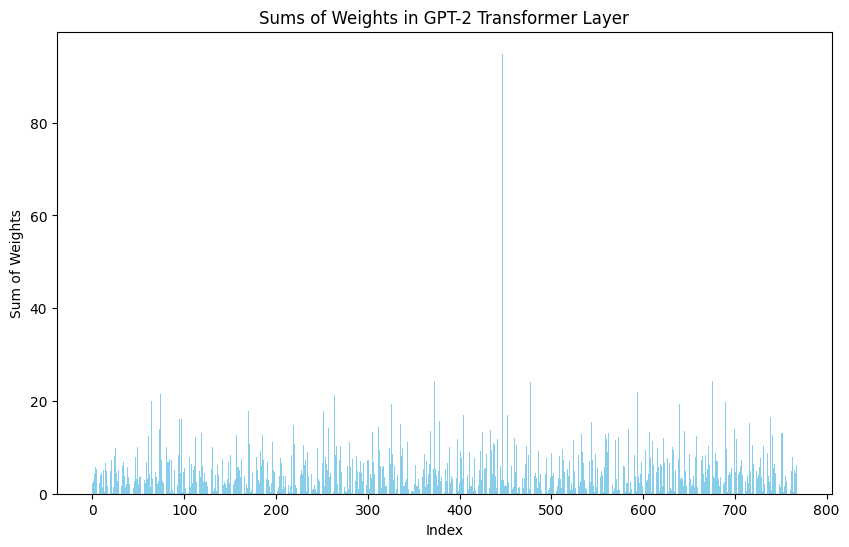

In [137]:
weight = parameters['transformer.h.0.mlp.c_proj.weight']
sums = []
for i in range(weight.shape[-1]):
    sums.append(np.abs(sum(weight[:, i])))
# for i in range(weight.shape[0]):
#     sums.append(np.abs(sum(weight[i])))

print(len(sums))
print(np.mean(sums))


plt.figure(figsize=(10, 6))
plt.bar(range(len(sums)), sums, color='skyblue')

# Add title and labels
plt.title('Sums of Weights in GPT-2 Transformer Layer')
plt.xlabel('Index')
plt.ylabel('Sum of Weights')

# Display the chart
plt.show()


In [138]:
average = np.mean(sums)
total_over = 0

for index, item in enumerate(sums):
    if item > average*10:
        total_over += 1

print(total_over)
print (total_over / len(sums)*100)

1
0.13020833333333331


In [122]:
def matix_absmax_quantization(m1, int_type=np.int8):
    data_max = np.iinfo(int_type).max
    norm_range = math.floor((data_max)**(1/2)/ max(m1.shape))
    quantification_constant = norm_range/np.max(abs(m1))
    new_type = (m1 * quantification_constant).astype(int_type)
    assert np.all((new_type >= -1*norm_range) & (new_type <= norm_range))
    return new_type, quantification_constant

def zeropoint_quantization(x, data_type):
    data_range = np.iinfo(data_type).max- np.iinfo(data_type).min
    q_c = data_range / (np.max(x)- np. min(x))
    z_p = -1* np.round(q_c * np.min(x)) + np.iinfo(data_type).min
    type_x = np.round(q_c * x + z_p).astype(data_type)
    return type_x, q_c, z_p

In [135]:
def vector_quant_matmul(m1, m2, quantization_method):
    matrix = np.empty((m1.shape[0], m2.shape[-1]))
    for row_num in range(len(m1)):
        for col_num in range(m2.shape[-1]):
            row = m1[row_num]
            col = m2[:, col_num]
            if quantization_method == 'absmax':
                int_row, row_const = matix_absmax_quantization(row, qualtization_type)
                int_col, col_const = matix_absmax_quantization(col, qualtization_type)
                int_dot = np.dot(int_row, int_col)
                float_dot = int_dot.astype(np.float64)* 1/(row_const * col_const)
            if np.isnan(float_dot):
                float_dot = 0
            matrix[row_num][col_num] = float_dot
    return matrix

def separate_outliers(m1, m2, quantization_method):
    col_sums = []
    for i in range(m1.shape[-1]):
        col_sums.append(np.abs(sum(m1[:, i])))
    col_sum_mean = np.mean(col_sums)

    m1_outliers = np.empty((m1.shape[0], 0))
    m2_outliers = np.empty((0 ,m2.shape[-1]))
    m1_inliers = np.empty((m1.shape[0], 0))
    m2_inliers = np.empty((0 ,m2.shape[-1]))

    for index, item in enumerate(col_sums):
        if item > col_sum_mean*10:
            m1_outliers = np.hstack((m1_outliers, m1[:, index][:, np.newaxis]))
            m2_outliers = np.vstack((m2_outliers, m2[index]))
        else:
            m1_inliers = np.hstack((m1_inliers, m1[:, index][:, np.newaxis]))
            m2_inliers = np.vstack((m2_inliers, m2[index]))

    print(m1_outliers.shape)

    outliers = np.matmul(m1_outliers, m2_outliers)
    inliers = vector_quant_matmul(m1_inliers, m2_inliers, quantization_method)

    return outliers + inliers


def nd_tensor_product(m1, m2, quantization_method = 'absmax'):
    ans_shape = m1.shape[:-2] + (m1.shape[-2], m2.shape[-1])
    ans = np.empty(ans_shape)
    if len(ans_shape) < 3:
        return separate_outliers(m1, m2, quantization_method)
    else:
        for i in range(ans_shape[0]):
            ans[i] = nd_tensor_product(m1[i], m2[i], quantization_method=quantization_method)
    return ans

In [136]:
iterations = 1000
qualtization_type = np.int8

# absmax_diff = 0
# zeropoint_diff = 0

# for _ in range(iterations):
#     a = np.random.uniform(-20, 20, size=(2, 10, 4))
#     b = np.random.uniform(-20, 20, size=(2, 4, 10))

#     actual = a @ b

#     absmax_quantized = nd_tensor_product(a,b, quantization_method = 'absmax')
#     absmax_loss = np.abs(np.mean(absmax_quantized - actual))
#     absmax_diff += absmax_loss

# print(f'abs loss {absmax_diff/iterations}')

a = np.random.uniform(-20, 20, size=(768, 100))
absmax_quantized = nd_tensor_product(weight,a, quantization_method = 'absmax')
print(absmax_quantized.shape)

(3072, 1)


/tmp/ipykernel_1644001/873596053.py:11: RuntimeWarning: invalid value encountered in scalar divide
  float_dot = int_dot.astype(np.float64)* 1/(row_const * col_const)


(3072, 100)
